# Earthdata Webinar: Examining Hurricane Milton's Milestones with NASA's GES DISC Datasets

Author: Chris Battisto (christopher.m.battisto@nasa.gov)

Attendee:

### Overview




### Prerequisites

- A valid [Earthdata Login account](https://urs.earthdata.nasa.gov/)
    - Approval of the "NASA GESDISC DATA ARCHIVE" application by following this guide: https://disc.gsfc.nasa.gov/earthdata-login
    - Generation of the `.netrc` and `.dodsrc` files (both files will be generated in this notebook)
- Python >=3.9
- [Xarray](https://docs.xarray.dev/en/stable/)
- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [NumPy](https://numpy.org/)
- [earthaccess](https://github.com/nsidc/earthaccess)


You can run this tutorial in your browser using Colab:<br>

<a target="_blank" href="https://colab.research.google.com/github/nasa/gesdisc-tutorials/blob/jan-2025-earthdata-webinar/webinars/January_29th_2025_Earthdata_Webinar.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 1. Install Packages and Import Libraries

In [ ]:
! pip install earthaccess -q
! pip install cartopy -q

In [208]:
import earthaccess
import requests
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### 2. Authenticate with Earthdata Login Servers

In [13]:
# persist=True will prompt for an Earthdata login/password
auth = earthaccess.login(persist=True)

### 3. Search for Granules

Due to the nature of Level 2 granules, we recommend using the [Earthdata Search graphical web tool](https://search.earthdata.nasa.gov) to search for granules over your area and time of interest. The Earthdata Search tool uses the [Content Metadata Repository (CMR)](https://www.earthdata.nasa.gov/about/esdis/eosdis/cmr#:~:text=NASA's%20Common%20Metadata%20Repository%20(CMR,system%20for%20all%20EOSDIS%20metadata.) to return granules that are inside the specified bounding box, or time period. Please note that this is ***not*** a subsetting service; variable subsetting will be performed before downloading using the OPeNDAP service, and spatiotemporal subsetting will be performed in this notebook using `Xarray`.

To view the metadata of each granule, please visit these links below:

- [GPM_2ADPR](https://search.earthdata.nasa.gov/search/granules?p=C2179081499-GES_DISC&pg[0][v]=f&pg[0][qt]=2024-10-08T00%3A00%3A00.000Z%2C2024-10-08T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&g=G3262642378-GES_DISC&q=gpm_2adpr&tl=1737127400!3!!&lat=-0.463195000000006&zoom=0)
- [TROPICS03MIRSL2B_1.0](https://search.earthdata.nasa.gov/search/granules?p=C3255751009-GES_DISC&pg[0][v]=f&pg[0][qt]=2024-10-09T23%3A00%3A00.000Z%2C2024-10-10T06%3A00%3A00.000Z&pg[0][gsk]=-start_date&g=G3302082503-GES_DISC&q=TROPICS03MIRSL2B_1.0&sb[0]=-85.45524%2C24.51801%2C-78.707%2C30.84377&tl=1737127400!3!!&lat=0.28125&long=0.28125&zoom=0)
- [TROPICS03PRPSL2B_1.0](https://search.earthdata.nasa.gov/search/granules?p=C3254839500-GES_DISC&pg[0][v]=f&pg[0][gsk]=-start_date&g=G3267498440-GES_DISC&q=TROPICS03PRPSL2B_1.0&sb[0]=-85.45524%2C24.51801%2C-78.707%2C30.84377&qt=2024-10-09T23%3A00%3A00.000Z%2C2024-10-10T06%3A00%3A00.000Z&tl=1737127400!3!!&lat=-0.7424050000000015&zoom=0)
- [TROPICS03URADL2A_1.0](https://search.earthdata.nasa.gov/search/granules?p=C3179859133-GES_DISC&pg[0][v]=f&pg[0][qt]=2024-10-08T00%3A00%3A00.000Z%2C2024-10-08T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&g=G3261882525-GES_DISC&q=TROPICS03URADL2A_1.0&sb[0]=-85.45524%2C24.51801%2C-78.707%2C30.84377&tl=1737127400!3!!&lat=-0.9123799999999989&zoom=0)
- [TROPICS03TCIEL2B_1.0](https://search.earthdata.nasa.gov/search/granules?p=C3279630448-GES_DISC&pg[0][v]=f&pg[0][qt]=2024-10-08T00%3A00%3A00.000Z%2C2024-10-10T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&g=G3285438117-GES_DISC&q=TROPICS03TCIEL2B_1.0&sb[0]=-85.45524%2C24.51801%2C-78.707%2C30.84377&tl=1737127400!3!!&lat=0.28125&long=0.28125&zoom=0)


In [232]:
gpm_results = earthaccess.search_data(
    short_name="GPM_2ADPR",   # Replace with the correct short name
    version="07",
    granule_ur="GPM_2ADPR.07:2A.GPM.DPR.V9-20240130.20241008-S191016-E204329.060264.V07C.HDF5"
)

mirs_results = earthaccess.search_data(
    short_name="TROPICS03MIRSL2B",   # Replace with the correct short name
    version="1.0",
    granule_ur="TROPICS03MIRSL2B.1.0:TROPICS03.MIRS.L2B.Orbit07622.V02-07.ST20241010-014135.ET20241010-031549.CT20241114-064700.nc"
)

prps_results = earthaccess.search_data(
    short_name="TROPICS03PRPSL2B",   # Replace with the correct short name
    version="1.0",
    granule_ur="TROPICS03PRPSL2B.1.0:TROPICS03.PRPS.L2B.Orbit07623.V04-02.ST20241010-031549.ET20241010-045003.CT20241011-212752.nc"
)

urad_results = earthaccess.search_data(
    short_name="TROPICS03URADL2A",   # Replace with the correct short name
    version="1.0",
    granule_ur="TROPICS03URADL2A.1.0:TROPICS03.URAD.L2A.Orbit07591.V01-24.ST20241008-005947.ET20241008-023403.CT20241008-183119.nc"
)

tcie_results = earthaccess.search_data(
    short_name="TROPICS03TCIEL2B",   # Replace with the correct short name
    version="1.0",
    granule_ur="TROPICS03TCIEL2B.1.0:TROPICS03.TCIE.L2B.Orbit07617.V01-09.OT20241009-175800.AL162024.CT20241030-135745.nc"
)


In [241]:
mirs_results

[Collection: {'ShortName': 'TROPICS03MIRSL2B', 'Version': '1.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -162.49158, 'Latitude': 6.57354}, {'Longitude': -158.12256, 'Latitude': -0.14835}, {'Longitude': -152.87822, 'Latitude': -8.20845}, {'Longitude': -135.10356, 'Latitude': 3.7393}, {'Longitude': -140.0635, 'Latitude': 12.12288}, {'Longitude': -144.37029, 'Latitude': 18.94235}, {'Longitude': -162.49158, 'Latitude': 6.57354}]}}, {'Boundary': {'Points': [{'Longitude': -144.37029, 'Latitude': 18.94235}, {'Longitude': -140.0635, 'Latitude': 12.12288}, {'Longitude': -135.10356, 'Latitude': 3.7393}, {'Longitude': -116.12354, 'Latitude': 13.84145}, {'Longitude': -120.27636, 'Latitude': 22.8739}, {'Longitude': -124.04691, 'Latitude': 30.10942}, {'Longitude': -144.37029, 'Latitude': 18.94235}]}}, {'Boundary': {'Points': [{'Longitude': -124.04691, 'Latitude': 30.10942}, {'Longitude': -120.27636, 'Latitude': 22.8739}, {'Lon

### 4. Create OPeNDAP Variable Subset URLs

We can utilize the OPeNDAP service to only subset the variables that we want, and download them. We can parse out the OPeNDAP URLs from our `earthaccess` search queries and append the variable subsets to each link, before downloading them.

To view the variables available in each collection, and to view the OPeNDAP web subsetter tool, please visit the Dataset Landing Page for each collection, click the "OPeNDAP" button on the right of the page, and select the top-level granule. You will be see each variable, some of which have HDF groups embedded in their names, (e.g., `FS_SLV_precipRate`). We will copy and paste the variables that we want into each OPeNDAP URL creation routine, where they are formatted as ["constraint expressions"](https://docs.opendap.org/index.php/UserGuideOPeNDAPMessages#:~:text=The%20constraint%20expression%20attached%20to,of%20interest%20from%20a%20dataset.), denoted by the variable `ce`. Finally, we will print the links, which when clicked, will download the subsetted granule to your desktop (optional for this notebook).

#### 4a. Subset GPM_2ADPR

In [236]:
files = []

#### 4b. Subset TROPICS03TCIEL2B

In [194]:
for itm in tcie_results:  # Iterate over items in the results list
    for urls in itm['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each item
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Insert variables below. "ce" refers 
            ce = ".dap.nc4?dap4.ce={}%3B{}%3B{}%3B{}%3B{}".format("max_wind", "mslp", "longitude", "latitude", "quality_flag")
            opendap_url = urls['URL'] + ce
            print(opendap_url)
            files.append(opendap_url)  # Add the URL to the list

https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2B/TROPICS03TCIEL2B.1.0/2024/283/TROPICS03.TCIE.L2B.Orbit07617.V01-09.OT20241009-175800.AL162024.CT20241030-135745.nc.dap.nc4?dap4.ce=max_wind%3Bmslp%3Blongitude%3Blatitude%3Bquality_flag


#### 4c. Subset TROPICS03URADL2A

Because URAD is a Level 2A collection originally in NetCDF3 format, it does not have DAP4 constraint expression support

In [195]:
for itm in urad_results:  # Iterate over items in the results list
    for urls in itm['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each item
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Insert variables below
            # NOTE: This is a DAP2 constraint expression
            ce = ".nc4?{},{},{},{}".format("brightness_temperature", "calQualityFlag", "longitude", "latitude")
            opendap_url = urls['URL'] + ce
            print(opendap_url)
            files.append(opendap_url)  # Add the URL to the list

https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2A/TROPICS03URADL2A.1.0/2024/282/TROPICS03.URAD.L2A.Orbit07591.V01-24.ST20241008-005947.ET20241008-023403.CT20241008-183119.nc.nc4?brightness_temperature,calQualityFlag,longitude,latitude


#### 4d. Subset TROPICS03PRPSL2A

In [234]:
for itm in prps_results:  # Iterate over items in the results list
    for urls in itm['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each item
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Insert variables below. "ce" refers 
            ce = ".dap.nc4?dap4.ce={}%3B{}%3B{}%3B{}".format("rain_rate", "prps_flag", "losLon", "losLat")
            opendap_url = urls['URL'] + ce
            print(opendap_url)
            files.append(opendap_url)  # Add the URL to the list

https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2B/TROPICS03PRPSL2B.1.0/2024/284/TROPICS03.PRPS.L2B.Orbit07623.V04-02.ST20241010-031549.ET20241010-045003.CT20241011-212752.nc.dap.nc4?dap4.ce=rain_rate%3Bprps_flag%3BlosLon%3BlosLat


#### 4e. Subset TROPICS03MIRSL2A

In [239]:
for itm in mirs_results:  # Iterate over items in the results list
    for urls in itm['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each item
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Insert variables below. "ce" refers 
            ce = ".dap.nc4?dap4.ce={}%3B{}%3B{}%3B{}".format("rain_rate", "prps_flag", "losLon", "losLat")
            opendap_url = urls['URL'] + ce
            print(opendap_url)
            files.append(opendap_url)  # Add the URL to the list

https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2B/TROPICS03MIRSL2B.1.0/2024/284/TROPICS03.MIRS.L2B.Orbit07622.V02-07.ST20241010-014135.ET20241010-031549.CT20241114-064700.nc.dap.nc4?dap4.ce=rain_rate%3Bprps_flag%3BlosLon%3BlosLat


### Download OPeNDAP Granules

In [240]:
# Set the FILENAME string to the data file name, the LABEL keyword value, or any customized name. 
# Remember to include the same file extension as in the URL.

# Target directory for downloaded files
target_dir = "tropics_subsets"

# Create the directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Download each file
for fn in files:
    # Extract the base file name, truncating after the first ".nc"
    base_name = os.path.basename(fn.split(".nc", 1)[0] + ".nc")
    FILENAME = os.path.join(target_dir, base_name)
    
    # Make the HTTP request
    result = requests.get(fn)
    try:
        result.raise_for_status()
        with open(FILENAME, 'wb') as f:
            f.write(result.content)
        print(f'Contents of URL written to {FILENAME}')
    except Exception as e:
        print(f'Error downloading {fn}: {e}')

Contents of URL written to tropics_subsets/TROPICS03.PRPS.L2B.Orbit07623.V04-02.ST20241010-031549.ET20241010-045003.CT20241011-212752.nc
Error downloading https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2B/TROPICS03MIRSL2B.1.0/2024/284/TROPICS03.MIRS.L2B.Orbit07622.V02-07.ST20241010-014135.ET20241010-031549.CT20241114-064700.nc.dap.nc4?dap4.ce=rain_rate%3Bprps_flag%3BlosLon%3BlosLat: 400 Client Error: 400 for url: https://disc2.gesdisc.eosdis.nasa.gov/opendap/TROPICS_L2B/TROPICS03MIRSL2B.1.0/2024/284/TROPICS03.MIRS.L2B.Orbit07622.V02-07.ST20241010-014135.ET20241010-031549.CT20241114-064700.nc.dap.nc4?dap4.ce=rain_rate%3Bprps_flag%3BlosLon%3BlosLat


### Analysis 1: Plotting Brightness Temperature

Brightness temperature can be used to determine hurricane strength, 

In [205]:
xr.open_dataset("tropics_subsets/TROPICS03.URAD.L2A.Orbit07591.V01-24.ST20241008-005947.ET20241008-023403.CT20241008-183119.nc")

<xarray.Dataset>
Dimensions:                 (channels: 12, scans: 2828, spots: 81, bands: 5)
Dimensions without coordinates: channels, scans, spots, bands
Data variables:
    brightness_temperature  (channels, scans, spots) float32 ...
    latitude                (bands, scans, spots) float32 ...
    longitude               (bands, scans, spots) float32 ...
    calQualityFlag          (channels, scans, spots) int16 ...
Attributes: (12/46)
    SV_ID:                          3
    OrbitNumber:                    7591
    DataSetQuality:                 Validated-1 Data Maturity Level
    L1b_File_Creation_Date:         2024-Oct-08 18:18:36.589 UTC
    L0b_File_Creation_Date:         2024-Oct-08 03:50:57.628 UTC
    PayloadDriver_SW_Ver:           538510358
    ...                             ...
    publisher_institution:          NASA Goddard Earth Sciences (GES) Data an...
    L2a_SW_Version:                 1.2.4
    LongName:                       TROPICS03 L2a Unified Resolution Brightne...
    title:                          TROPICS03 L2a Unified Resolution Brightne...
    inputs:                         TROPICS03.BRTT.L1B.Orbit07591.V05-02.ST20...
    history:                        2025-01-24 16:45:49 GMT hyrax-1.16.4 http...





These are the Bad Data uint8 values: [192, 193, 224, 225, 228, 229, 101, 100, 96, 241, 160, 161, 169, 168]


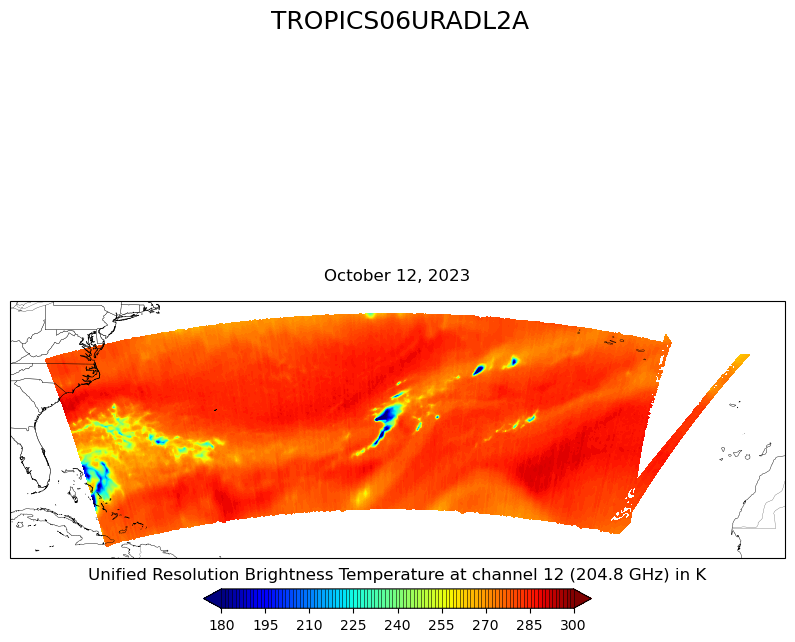

In [259]:
# Open file
ds = xr.open_dataset("tropics_subsets/TROPICS03.URAD.L2A.Orbit07591.V01-24.ST20241008-005947.ET20241008-023403.CT20241008-183119.nc")

cs = 12 #The channel
bas = 5  #The band

channel = [1,2,3,4,5,6,7,8,9,10]
band = [1,2,3,4,5]
ghz_list = [91.655,114.50,115.95,116.65,117.25,117.80,118.24,118.58,184.41,186.51,190.31,204.8]

atemp_old = ds['brightness_temperature'][cs-1,:,:].values
qfc = ds['calQualityFlag'][cs-1,:,:].values
lat_old = ds['latitude'][bas-1,:,:].values
lon_old = ds['longitude'][bas-1,:,:].values

#Scans and Spots Size
sc = atemp_old.shape[0]
sp = atemp_old.shape[1]

#Quality Flag zero arrays
lat = np.zeros((sc,sp))
lon = np.zeros((sc,sp))
atemp = np.zeros((sc,sp))


#Print quality flag list
qfc_l=[]
for scans in range(0,sc):
        for spots in range(0,sp):
                qfc_l.append(qfc[scans][spots])
#print('The quality flag list: ', qfc_l)


#Create condensed list of all quality flags uint8 values
count=0
empty_list=[]
for number in qfc_l:
    if(number not in empty_list):
        count+=1
        empty_list.append([number])
#print('Unique values list: ', empty_list)
arr = np.array(empty_list, dtype=np.uint8)


#Unpack uint8 into bits into another list
bits = np.unpackbits(arr,axis=1)
#print('Condensed list: ',arr)
#print('Bits in condensed list: ', bits[0])


#Create a loop with conditions that will parse out and identify bad data
bad_uint=[]
for row in range(0,len(arr)):
    for ind in range(1,5): #Only Bit 2-5 
        if bits[row][ind]==1:
            if(arr[row] not in bad_uint):
                bad_uint.append(arr[row][0])
print('\n'*3)
print('These are the Bad Data uint8 values:', bad_uint)

#Remove Bad Data
for scans in range(0,sc):
        for spots in range(0,sp):
                if qfc[scans][spots] in bad_uint:
                        #print(qfc[scans][spots])
                        #lat[scans][spots]=np.nan
                        #lon[scans][spots]=np.nan
                        atemp[scans][spots]=np.nan
                else:
                        atemp[scans][spots]=atemp_old[scans][spots]
#Plot
fig,(ax) = plt.subplots(1, 1, figsize=(10, 8),subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.BORDERS, linewidth=0.15,edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.2,edgecolor='black')
ax.coastlines(resolution='10m', color='black',linewidth=0.3)
#ax.set_extent([-97, -81, 21, 27], crs=ccrs.PlateCarree())
start =500
end =1100
levels = np.linspace(180,300,100)
level_ticks = np.arange(180, 305, 15)
cmap=plt.get_cmap('jet')

contours = ax.contourf(lon_old[start:end],lat_old[start:end],atemp_old[start:end],levels,cmap=cmap,vmin=min(levels), vmax=max(levels), extend='both')

clb = plt.colorbar(contours,orientation='horizontal',extend = 'both',ticks = level_ticks,shrink=0.5,drawedges=True,pad=0.05)

clb.ax.xaxis.set_label_position('top')
clb.set_label(label='Unified Resolution Brightness Temperature at channel '+ str(cs) +' (' + str(ghz_list[cs-1]) + ' GHz) in K',size=12,labelpad=7.25)#*

#Titles
plt.suptitle('TROPICS06URADL2A',x=0.515,y=0.95,fontsize=18)#*
ax.set_title('October 12, 2023\n', fontsize=12,y=0.98,ha='center')#*
#plt.savefig('TROPICS06URADL2A_0_2.png')#*
plt.show()

### Analysis 3: Plotting Max Winds/MSLP

In [223]:
ds = xr.open_mfdataset("tropics_subsets/TROPICS03.TCIE.L2B.Orbit07617.V01-09.OT20241009-175800.AL162024.CT20241030-135745.nc")

rain_r = ds['rain_rate'].values
qfc = ds['prps_flag'].values
lat_old = ds['losLat'].values
lon_old = ds['losLon'].values

#Scans and Spots Size
sc = rain_r.shape[0]
sp = rain_r.shape[1]
print('Scans',sc)
print('Spots',sp)
#Quality Flag zero arrays
lat = np.zeros((sc,sp))
lon = np.zeros((sc,sp))
rain_rn = np.zeros((sc,sp))

#Print quality flag list
qfc_l=[]
for scans in range(0,sc):
        for spots in range(0,sp):
                qfc_l.append(qfc[scans][spots])
#print('The quality flag list: ', qfc_l)


#Create condensed list of all quality flags uint8 values
count=0
empty_list=[]
for number in qfc_l:
    if(number not in empty_list):
        count+=1
        empty_list.append([number])
#print('Unique values list: ', empty_list)
arr = np.array(empty_list, dtype=np.uint8)

#Unpack uint8 into bits into another list
bits = np.unpackbits(arr,axis=1)
print('\n'*3)
#print('Condensed list: ',arr)
print('Bits in condensed list: ', bits[0])


#Create a loop with conditions that will parse out and identify bad data
bad_uint=[]
for row in range(0,len(arr)):
    #for ind in range(1,8):#Only Bit 3
    for ind in range(2,6): #Only Bit 2-5
        if bits[row][ind]==1:
            if(arr[row] not in bad_uint):
                bad_uint.append(arr[row][0])
print('\n'*3)
print('These are the Bad Data uint8 values:', bad_uint)


#Remove Bad Data
for scans in range(0,sc):
        for spots in range(0,sp):
                if (rain_r[scans][spots]<0) or (qfc[scans][spots] in bad_uint):
                        rain_rn[scans][spots]=np.nan
                else:
                        rain_rn[scans][spots]=rain_r[scans][spots]

#Plot
fig,(ax) = plt.subplots(1, 1, figsize=(10, 8),subplot_kw={'projection': ccrs.PlateCarree()})

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=0.15,edgecolor='black')
#ax.add_feature(cfeature.STATES, linewidth=0.2,edgecolor='black')
ax.coastlines(resolution='10m', color='black',linewidth=0.3)
ax.set_extent([120,142,7,19], crs=ccrs.PlateCarree())

levels = np.linspace(1.5,17.5,75)
level_ticks = np.arange(1.5, 18, 2)
cmap=plt.get_cmap('jet')

contours = ax.contourf(lon_old,lat_old,rain_rn,levels,cmap=cmap,vmin=min(levels), vmax=max(levels))

#Colobar 
clb = plt.colorbar(contours,orientation='horizontal',extend = 'None',ticks = level_ticks, shrink=0.5, drawedges=True, pad=0.05)

clb.ax.xaxis.set_label_position('top')
clb.set_label(label='PRPS derived rain rates [mm/hr]',size=12,labelpad=7.25)

#Titles
plt.suptitle('TROPICS01PRPSL2B',x=0.51,y=0.97,fontsize=18)
ax.set_title(str(month_dict[month])+ ' ' + day +', '+year+'\n', fontsize=12,y=0.98,ha='center')#*
#plt.savefig('TROPICS01PRPSL2B_1.0.png')#*
plt.show()

KeyError: "No variable named 'rain_rate'. Variables on the dataset include ['latitude', 'longitude', 'max_wind', 'quality_flag', 'mslp']"

In [224]:
xr.open_mfdataset("tropics_subsets/TROPICS03.TCIE.L2B.Orbit07617.V01-09.OT20241009-175800.AL162024.CT20241030-135745.nc")

<xarray.Dataset>
Dimensions:       (lat: 1, lon: 1, vmax: 1, qflag1: 1, mslpd: 1)
Dimensions without coordinates: lat, lon, vmax, qflag1, mslpd
Data variables:
    latitude      (lat) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude     (lon) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    max_wind      (vmax) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    quality_flag  (qflag1) int16 dask.array<chunksize=(1,), meta=np.ndarray>
    mslp          (mslpd) int32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    description:                     TCIE Tropical Cyclone intensity output
    ShortName:                       TROPICS03TCIEL2B
    LongName:                        TROPICS03 L2b Tropical Cyclone Intensity...
    Format:                          NetCDF-4
    ProcessingLevel:                 L2b
    Source:                          TROPICS03
    ...                              ...
    creator_institution:             Space Science & Engineering Center, Univ...
    publisher_name:                  GESDISC
    publisher_url:                   https://disc.gsfc.nasa.gov/
    publisher_email:                 gsfc-dl-help-disc@mail.nasa.gov
    publisher_institution:           NASA Goddard Earth Sciences (GES) Data a...
    DODS_EXTRA.Unlimited_Dimension:  time

### Analysis 4: Rain Rate using PRPS

Scans 2591
Spots 81




Bits in condensed list:  [1 1 1 1 0 1 0 1]




These are the Bad Data uint8 values: [245, 246, 247, 248]


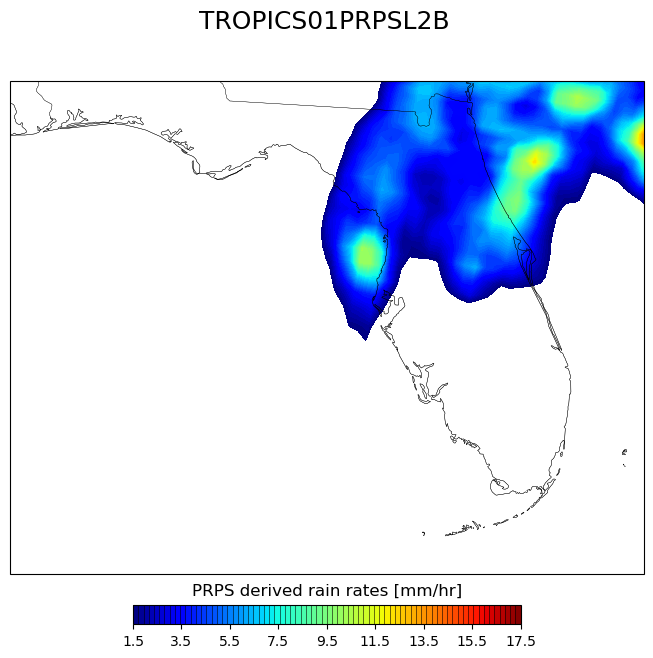

In [ ]:
#Read data in and Establish Variables
ds = xr.open_mfdataset("tropics_subsets/TROPICS03.PRPS.L2B.Orbit07623.V04-02.ST20241010-031549.ET20241010-045003.CT20241011-212752.nc")

rain_r = ds['rain_rate'].values
qfc = ds['prps_flag'].values
lat_old = ds['losLat'].values
lon_old = ds['losLon'].values

#Scans and Spots Size
sc = rain_r.shape[0]
sp = rain_r.shape[1]
print('Scans',sc)
print('Spots',sp)
#Quality Flag zero arrays
lat = np.zeros((sc,sp))
lon = np.zeros((sc,sp))
rain_rn = np.zeros((sc,sp))

#Print quality flag list
qfc_l=[]
for scans in range(0,sc):
        for spots in range(0,sp):
                qfc_l.append(qfc[scans][spots])
#print('The quality flag list: ', qfc_l)


#Create condensed list of all quality flags uint8 values
count=0
empty_list=[]
for number in qfc_l:
    if(number not in empty_list):
        count+=1
        empty_list.append([number])
#print('Unique values list: ', empty_list)
arr = np.array(empty_list, dtype=np.uint8)

#Unpack uint8 into bits into another list
bits = np.unpackbits(arr,axis=1)
#print('Condensed list: ',arr)
print('Bits in condensed list: ', bits[0])


#Create a loop with conditions that will parse out and identify bad data
bad_uint=[]
for row in range(0,len(arr)):
    #for ind in range(1,8):#Only Bit 3
    for ind in range(2,6): #Only Bit 2-5
        if bits[row][ind]==1:
            if(arr[row] not in bad_uint):
                bad_uint.append(arr[row][0])

print('These are the Bad Data uint8 values:', bad_uint)


#Remove Bad Data
for scans in range(0,sc):
        for spots in range(0,sp):
                if (rain_r[scans][spots]<0) or (qfc[scans][spots] in bad_uint):
                        rain_rn[scans][spots]=np.nan
                else:
                        rain_rn[scans][spots]=rain_r[scans][spots]

#Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.BORDERS, linewidth=0.15,edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.2,edgecolor='black')
ax.coastlines(resolution='10m', color='black',linewidth=0.3)
ax.set_extent([-88, -79, 24, 31], crs=ccrs.PlateCarree())

levels = np.linspace(1.5,17.5,75)
level_ticks = np.arange(1.5, 18, 2)
cmap=plt.get_cmap('jet')

contours = ax.contourf(lon_old,lat_old,rain_rn,levels,cmap=cmap,vmin=min(levels), vmax=max(levels))

#Colobar 
clb = plt.colorbar(contours,orientation='horizontal',extend = 'None',ticks = level_ticks, shrink=0.5, drawedges=True, pad=0.05)

clb.ax.xaxis.set_label_position('top')
clb.set_label(label='PRPS derived rain rates [mm/hr]',size=12,labelpad=7.25)

#Titles
plt.suptitle('TROPICS01PRPSL2B',x=0.51,y=0.97,fontsize=18)
#ax.set_title(str(month_dict[month])+ ' ' + day +', '+year+'\n', fontsize=12,y=0.98,ha='center')#*
#plt.savefig('TROPICS01PRPSL2B_1.0.png')#*
plt.show()

### Analysis 5: Precipitable Water using MIRS

Scanline 2584
Field_of_view 81
The minimum value for Total Precipitable Water:  1.6
The maximum value for Total Precipitable Water:  85.4


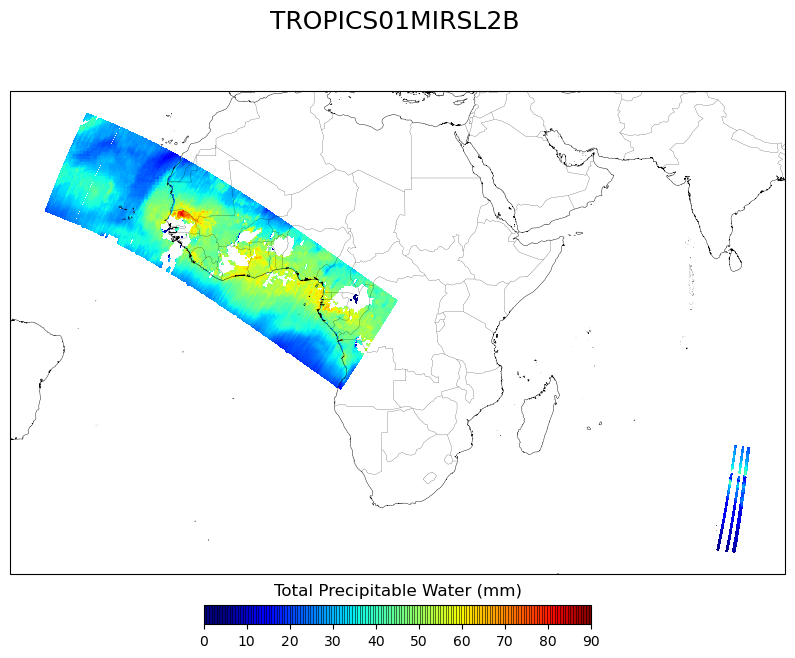

In [258]:
ds = xr.open_mfdataset("tropics_subsets/TROPICS03.MIRS.L2B.Orbit07622.V02-07.ST20241010-014135.ET20241010-031549.CT20241114-064700.nc")

cs = 12 #The channel
bas = 5 #The band

channel = [1,2,3,4,5,6,7,8,9,10]
band = [1,2,3,4,5]
ghz_list = [91.655,114.50,115.95,116.65,117.25,117.80,118.24,118.58,184.41,186.51,190.31,204.8]

TPW = ds['TPW'].values
qfc = ds['Qc'].values
lat_old = ds['Latitude'].values
lon_old = ds['Longitude'].values


#Scans and Spots Size
sc = TPW.shape[0]
sp = TPW.shape[1]
print('Scanline',sc)
print('Field_of_view',sp)
#Quality Flag zero arrays
lat = np.zeros((sc,sp))
lon = np.zeros((sc,sp))
atemp = np.zeros((sc,sp))

# Loop through the data and overwrite bad values with NaN
for scans in range(sc):
    for spots in range(sp):
        # Direct indexing ensures scalar access
        if qfc[scans, spots, 1] < 2 and TPW[scans, spots] > 0:  # Skip good data, select quality control flag 0
            continue
        else:
            TPW[scans, spots] = np.nan  # Overwrite bad data with NaN

#Check to see the lowest value
print('The minimum value for Total Precipitable Water: ',np.nanmin(TPW))
print('The maximum value for Total Precipitable Water: ',np.nanmax(TPW))

#Plot
fig,(ax) = plt.subplots(1, 1, figsize=(10, 8),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linewidth=0.15,edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.2,edgecolor='black')
ax.coastlines(resolution='10m', color='black',linewidth=0.3)
#ax.set_extent([-88, -79, 24, 31], crs=ccrs.PlateCarree())

start =1000
end =1800
levels = np.linspace(0,90,150)
level_ticks = np.arange(0,91,10)
cmap=plt.get_cmap('jet')
#cmap.set_bad("white", alpha=0)

contours = ax.contourf(lon_old[start:end],lat_old[start:end],TPW[start:end],levels,cmap=cmap,vmin=4, vmax=max(levels))

#contours = ax.contourf(lon_old[start:end],lat_old[start:end],TPW[start:end],cmap=cmap)
#clb = plt.colorbar(contours,orientation='horizontal',extend = 'None', shrink=0.5, drawedges=True, pad=0.05)

clb = plt.colorbar(contours,orientation='horizontal',extend = 'None', ticks = level_ticks, shrink=0.5, drawedges=True, pad=0.05)
clb.ax.xaxis.set_label_position('top')
clb.set_label(label='Total Precipitable Water (mm)',size=12,labelpad=7.25)#*

#Titles
plt.suptitle('TROPICS01MIRSL2B',x=0.51,y=0.97,fontsize=18)#*
#ax.set_title('February 19, 2023\n', fontsize=12,y=0.98,ha='center')#*
#plt.savefig('Freddy_TROPICS01MIRSL2B_Feb19_1.0.png')#*
plt.show()